<a href="https://colab.research.google.com/github/ArminD93/Intel-Image-Classification/blob/dev/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intel Image Classification**




In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil # Pomaga w kopiowaniu plików
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#!unzip -q "/content/drive/My Drive/ColabNotebooks/intel_image/data/intel_image.zip" 

In [0]:
# Wyczyścimy katalog roboczy
!rm -rf ./images

In [4]:
base_dir = './intel_image' # Przypisujemy katalog bazowy

raw_no_of_files = {}

classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
for dir in classes: # ile mamy zdjęć dla poszczególnych klas
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('buildings', 2628), ('forest', 2745), ('glacier', 2957), ('mountain', 3037), ('sea', 2784), ('street', 2883)])

In [0]:
# Utworzenie katalogów train, test, valid
data_dir = './images' # Przypisujemy katalog bazowy

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog dla zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog dla zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog dla  zbioru testowego

# Wskażemy klasy
train_buildings_dir = os.path.join(train_dir, 'buildings')
train_forest_dir = os.path.join(train_dir, 'forest')
train_glacier_dir = os.path.join(train_dir, 'glacier')
train_mountain_dir = os.path.join(train_dir, 'mountain')
train_sea_dir = os.path.join(train_dir, 'sea')
train_street_dir = os.path.join(train_dir, 'street')

valid_buildings_dir = os.path.join(valid_dir, 'buildings')
valid_forest_dir = os.path.join(valid_dir,    'forest'  )
valid_glacier_dir = os.path.join(valid_dir, 'glacier')
valid_mountain_dir = os.path.join(valid_dir, 'mountain')
valid_sea_dir = os.path.join(valid_dir, 'sea')
valid_street_dir = os.path.join(valid_dir, 'street')

test_buildings_dir = os.path.join(test_dir, 'buildings')
test_forest_dir = os.path.join(test_dir, 'forest')
test_glacier_dir = os.path.join(test_dir, 'glacier')
test_mountain_dir = os.path.join(test_dir, 'mountain')
test_sea_dir = os.path.join(test_dir, 'sea')
test_street_dir = os.path.join(test_dir, 'street')

# Pętla, która przejdzie po naszych katalogach
for i, directory in enumerate([train_dir, valid_dir, test_dir]):
    if not os.path.exists(directory): # Jeśli takie ścieżki nie istenieją, to po prostu utowrzymy te katalogi
        os.mkdir(directory)

# To samo wykonamy z katalogami w trzecim pozimie
dirs = [train_buildings_dir, train_forest_dir, train_glacier_dir, train_mountain_dir, train_sea_dir, train_street_dir,
        valid_buildings_dir, valid_forest_dir, valid_glacier_dir, valid_mountain_dir, valid_sea_dir, valid_street_dir,
        test_buildings_dir, test_forest_dir, test_glacier_dir, test_mountain_dir, test_sea_dir, test_street_dir 
        ]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)       

In [0]:
# Teraz musimy znać pełne ściżki do naszych plików
base_dir = './intel_image' # Przypisujemy katalog bazowy, gdzie są zdjęcia

# Do zmiennej _fnames przypisujemy wylistowanie katalogu z katalogu bazowego, tam gdzie są zdjęcia
buildings_files_names = os.listdir(os.path.join(base_dir, 'buildings')) 
forest_files_names = os.listdir(os.path.join(base_dir,    'forest'))
glacier_files_names = os.listdir(os.path.join(base_dir,   'glacier'))
mountain_files_names = os.listdir(os.path.join(base_dir,  'mountain'))
sea_files_names = os.listdir(os.path.join(base_dir,       'sea'))
street_files_names = os.listdir(os.path.join(base_dir,    'street'))

test_files_names = os.listdir(os.path.join(base_dir,      'test'))

In [0]:
# W kolejnym kroku określimy rozmiar danych, które będziemy potrzebować do naszego modelu.

# W związku z tym, że są różne wartości danych, w różnych klasach,
# Wybierzemy minimalną długość z tych dwóch klas i przypiszemy do zmiennej rozmiar
size = min(len(buildings_files_names), len(forest_files_names), len(glacier_files_names), len(mountain_files_names), len(sea_files_names), len(street_files_names))

train_size = int(np.floor(0.7 * size)) # rozmiar danych treningowych to 70% wszystkich zdjęć                                     
valid_size = int(np.floor(0.2 * size)) 
test_size = size - (train_size + valid_size) # Testowy zbiór to będzie 10%


In [8]:
def filesCopy(directory_dir):

  train_id = train_size
  valid_id = train_size + valid_size
  test_id = train_size + valid_size + test_size

  for i, dictio in enumerate(directory_dir):
    dir_name = [val for val in directory_dir.values() ][i]
    label_name = dictio
    
    for i, fname in enumerate(dir_name[0]):
        if i <= train_id:                                  
            src = os.path.join(base_dir, label_name, fname)   
            dst = os.path.join(dir_name[1], fname)
            shutil.copyfile(src, dst)
        elif train_id < i <= valid_id:
            src = os.path.join(base_dir, label_name, fname)
            dst = os.path.join(dir_name[2], fname)      
            shutil.copyfile(src, dst)
        elif valid_id < i < test_id:
            src = os.path.join(base_dir, label_name, fname)     
            dst = os.path.join(dir_name[3], fname)
            shutil.copyfile(src, dst)

    print(f'{label_name} - zbiór treningowy:  { len(os.listdir(dir_name[1] )) } ')
    print(f'{label_name} - zbiór walidacyjny: { len(os.listdir(dir_name[2] )) } ')
    print(f'{label_name} - zbiór testowy:     { len(os.listdir(dir_name[3] )) } ')
    print()
# ----------------------------------------------------------------------------------------------------

directory_dir = {
                  'buildings' : [buildings_files_names,  train_buildings_dir,  valid_buildings_dir,  test_buildings_dir ],
                  'forest'    : [forest_files_names,     train_forest_dir,     valid_forest_dir,     test_forest_dir    ],
                  'glacier'   : [glacier_files_names,    train_glacier_dir,    valid_glacier_dir,    test_glacier_dir   ],   
                  'mountain'  : [mountain_files_names,   train_mountain_dir,   valid_mountain_dir,   test_mountain_dir  ],   
                  'sea'       : [sea_files_names,        train_sea_dir,        valid_sea_dir,        test_sea_dir       ],   
                  'street'    : [street_files_names,     train_street_dir,     valid_street_dir,     test_street_dir    ]   
                }

filesCopy(directory_dir)  

buildings - zbiór treningowy:  1840 
buildings - zbiór walidacyjny: 525 
buildings - zbiór testowy:     263 

forest - zbiór treningowy:  1840 
forest - zbiór walidacyjny: 525 
forest - zbiór testowy:     263 

glacier - zbiór treningowy:  1840 
glacier - zbiór walidacyjny: 525 
glacier - zbiór testowy:     263 

mountain - zbiór treningowy:  1840 
mountain - zbiór walidacyjny: 525 
mountain - zbiór testowy:     263 

sea - zbiór treningowy:  1840 
sea - zbiór walidacyjny: 525 
sea - zbiór testowy:     263 

street - zbiór treningowy:  1840 
street - zbiór walidacyjny: 525 
street - zbiór testowy:     263 



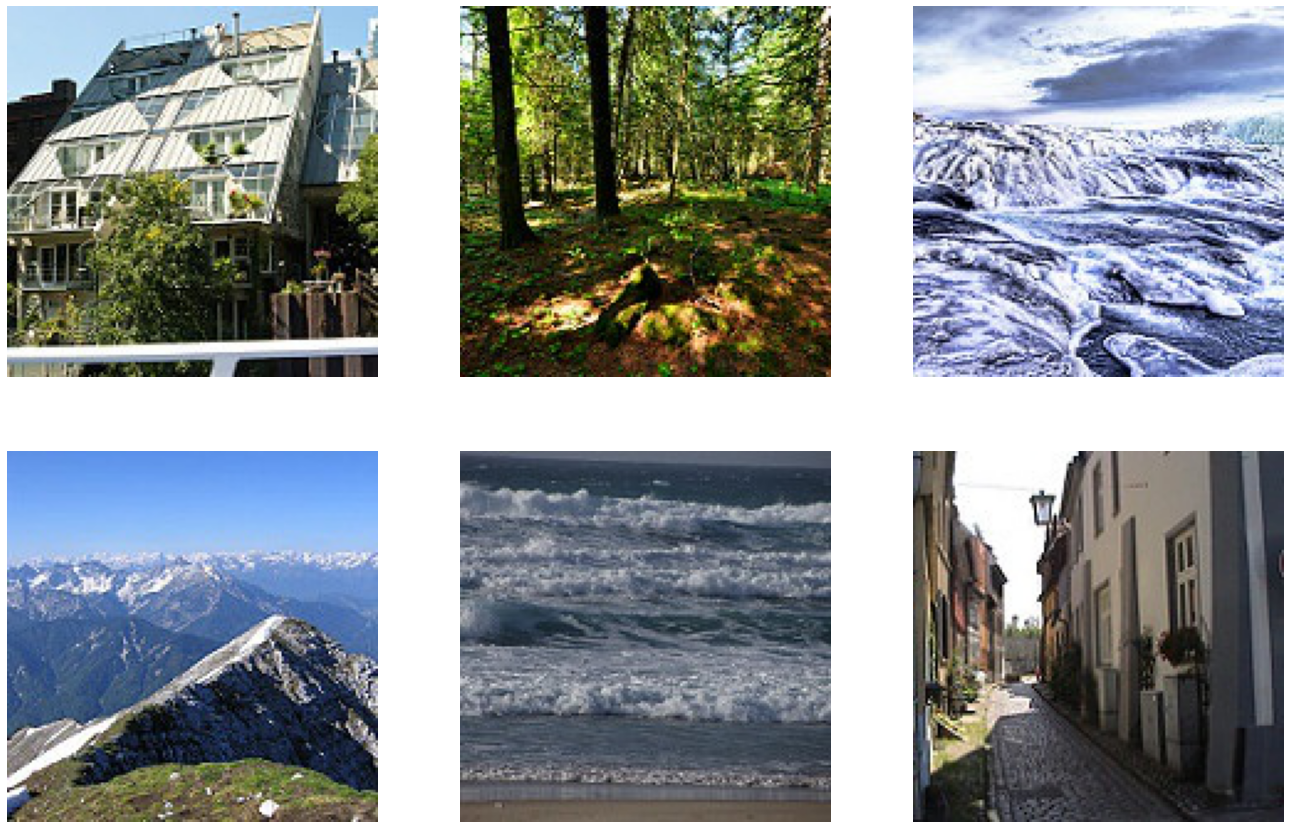

In [9]:
#@title Wybierz indeks przykładowe zdjęcia ze zbioru treningowego:

buildings_idx = 340 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(buildings_files_names))
img_path = os.path.join(train_buildings_dir, names_mapping[buildings_idx])
img_buildings = image.load_img(img_path)

forest_idx = 1028 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(forest_files_names))
img_path = os.path.join(train_forest_dir, names_mapping[forest_idx])
img_forest = image.load_img(img_path)

glacier_idx = 519 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(glacier_files_names))
img_path = os.path.join(train_glacier_dir, names_mapping[glacier_idx])
img_glacier = image.load_img(img_path)

mountain_idx = 1410 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(mountain_files_names))
img_path = os.path.join(train_mountain_dir, names_mapping[mountain_idx])
img_mountain = image.load_img(img_path)

sea_idx = 407 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(sea_files_names))
img_path = os.path.join(train_sea_dir, names_mapping[sea_idx])
img_sea = image.load_img(img_path)

street_idx = 925 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(street_files_names))
img_path = os.path.join(train_street_dir, names_mapping[street_idx])
img_street = image.load_img(img_path)

fig, ax = plt.subplots(2,3,figsize=(23, 15))

ax[0,0].imshow(img_buildings)
ax[0,1].imshow(img_forest)
ax[0,2].imshow(img_glacier)

ax[1,0].imshow(img_mountain)
ax[1,1].imshow(img_sea)
ax[1,2].imshow(img_street)


ax[0,0].axis(False)
ax[0,1].axis(False)
ax[0,2].axis(False)

ax[1,0].axis(False)
ax[1,1].axis(False)
ax[1,2].axis(False)

plt.show()

In [10]:
# Augmentacja danych

train_datagen = ImageDataGenerator(
    rotation_range=45,       # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,         # przeskalowujemy wszystkie obrazy o współczynnik 1/255
    width_shift_range=0.25,  # pionowe przekształcenia obrazu
    height_shift_range=0.25, # poziome przekształcenia obrazu
    shear_range=0.25,        # zares losowego przycianania obrazu
    zoom_range=0.25,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,    # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'      # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

valid_datagen = ImageDataGenerator(rescale=1./255.) 

# Budujemy generatory
train_generator = train_datagen.flow_from_directory(directory=train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')  
valid_generator = valid_datagen.flow_from_directory(directory=valid_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')

Found 11040 images belonging to 6 classes.
Found 3150 images belonging to 6 classes.


In [0]:
def display_augmented_images(directory, index):

    files_names = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = files_names[index]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)
    

    plt.figure(figsize=(23, 10))

    image_no = 1
    for batch in train_datagen.flow(x, batch_size=1):
        if image_no == 16:
            break      
        plt.subplot(3, 5, image_no)
        plt.axis(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        image_no += 1


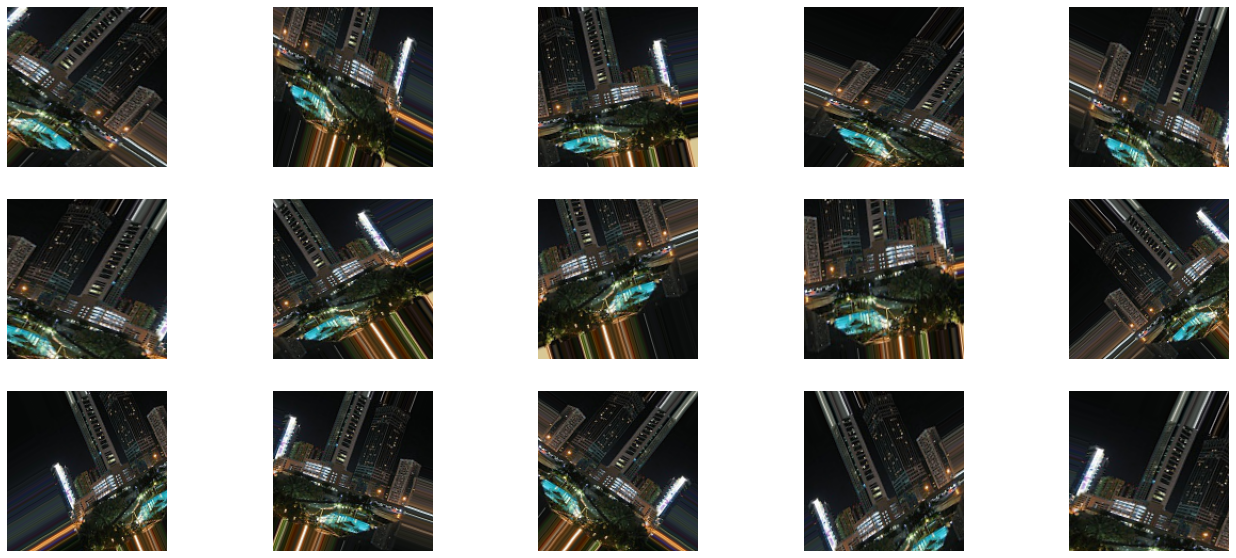

In [12]:
#@title Zbiór treningowy buildings:
index = 1334 #@param {type:'slider', min:0, max:1839}  
  
display_augmented_images(train_buildings_dir, index)

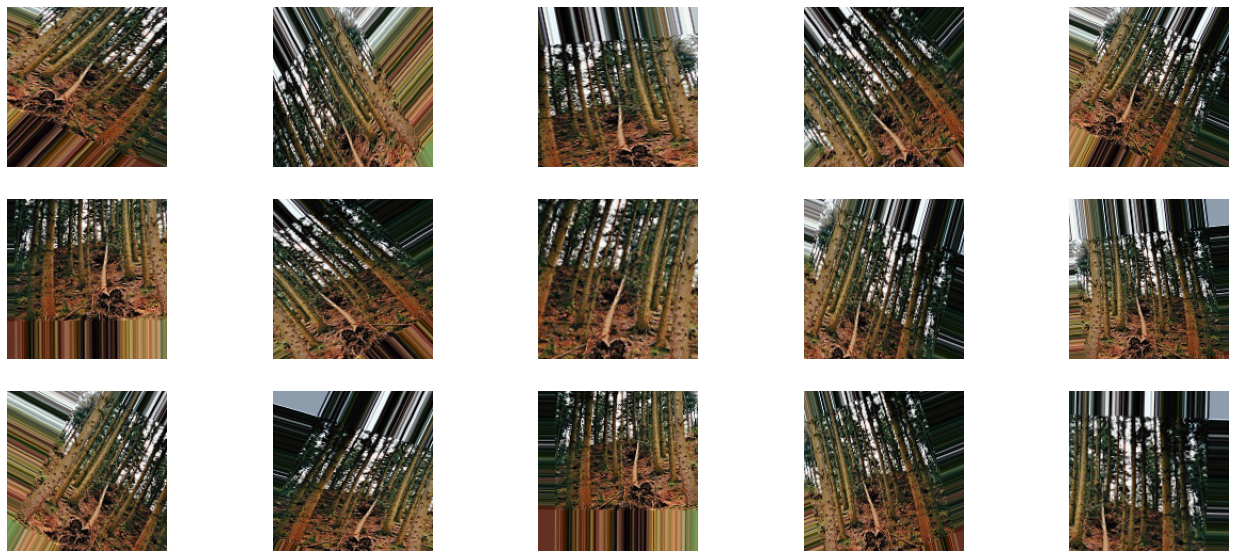

In [13]:
#@title Zbiór treningowy forest:
index = 458 #@param {type:'slider', min:0, max:1839}  

display_augmented_images(train_forest_dir, index)

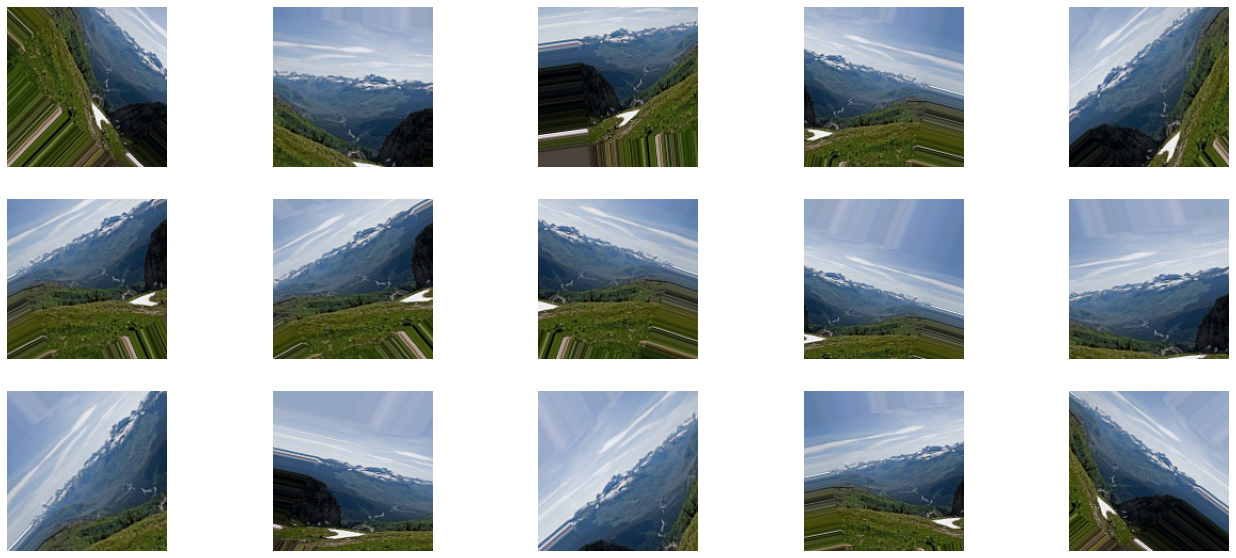

In [14]:
#@title Zbiór treningowy glacier:
index = 66 #@param {type:'slider', min:0, max:1839}  

display_augmented_images(train_glacier_dir, index)

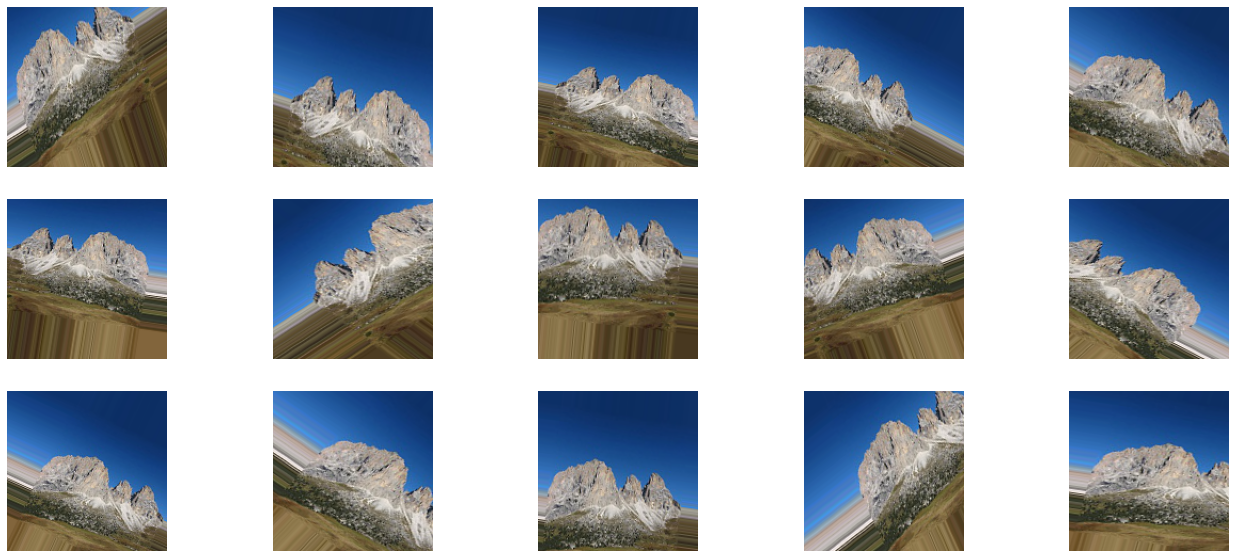

In [15]:
#@title Zbiór treningowy mountain:
index = 77 #@param {type:'slider', min:0, max:1839}  

display_augmented_images(train_mountain_dir, index)

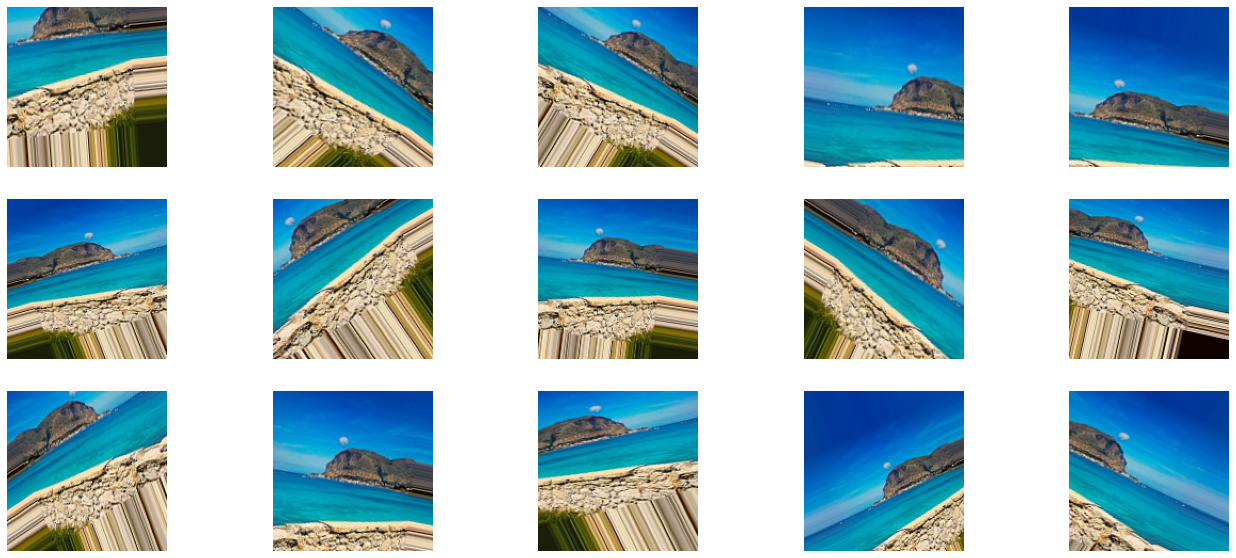

In [16]:
#@title Zbiór treningowy sea:
index = 839 #@param {type:'slider', min:0, max:1839}  

display_augmented_images(train_sea_dir, index)

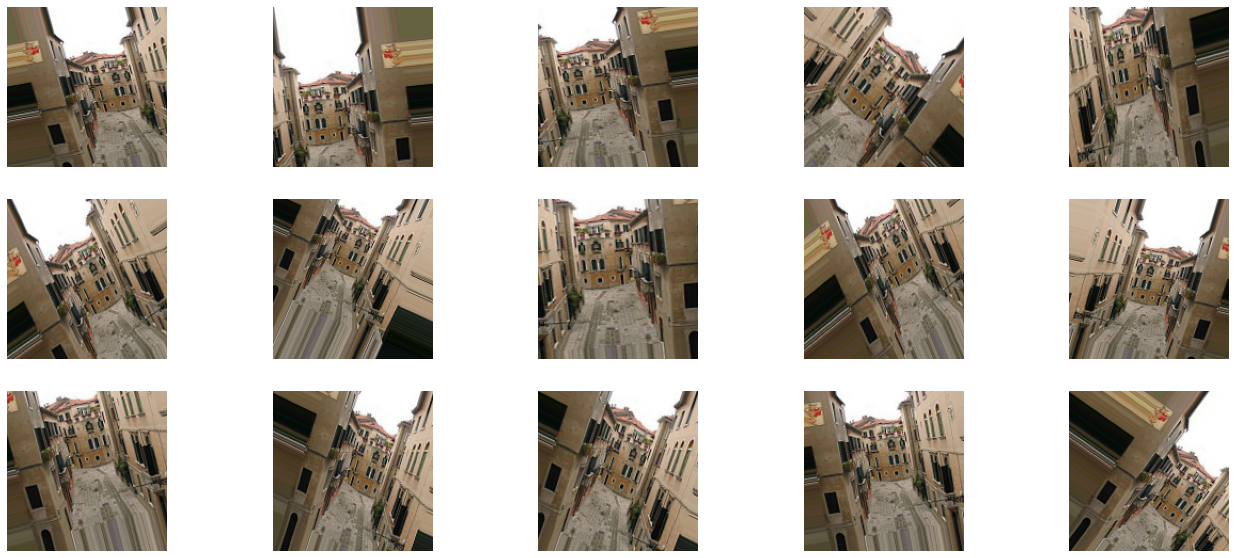

In [17]:
#@title Zbiór treningowy street:
index = 822 #@param {type:'slider', min:0, max:1839}  

display_augmented_images(train_street_dir, index)

In [18]:
model = Sequential()

model.add(layers.Conv2D(filters= 32, kernel_size=(7, 7), activation='relu', input_shape=(150, 150, 3)))                                                                                                     
model.add(layers.MaxPooling2D(pool_size=(2, 2)))  

model.add(layers.Conv2D(filters= 64, kernel_size=(3, 3), activation='relu')) 
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters= 128, kernel_size=(3, 3), activation='relu'))  

                 
model.add(layers.Flatten())
model.add(layers.Dense(units= 1024, activation='relu')) 

model.add(layers.Dense(units= 512, activation='relu')) 

model.add(layers.Dense(units= 6,   activation='softmax'))                    


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 144, 32)      4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 70, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 139392)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [20]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

history = model.fit_generator(generator=train_generator,  
                             steps_per_epoch=steps_per_epoch,
                             epochs=35,   
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/35
57/57 [==============================] - 12s 215ms/step - loss: 1.6267 - accuracy: 0.3350 - val_loss: 1.4088 - val_accuracy: 0.4297
Epoch 2/35
57/57 [==============================] - 12s 212ms/step - loss: 1.3814 - accuracy: 0.4567 - val_loss: 1.3017 - val_accuracy: 0.4727
Epoch 3/35
57/57 [==============================] - 12s 211ms/step - loss: 1.3193 - accuracy: 0.4753 - val_loss: 1.4224 - val_accuracy: 0.3906
Epoch 4/35
57/57 [==============================] - 12s 211ms/step - loss: 1.2712 - accuracy: 0.5022 - val_loss: 1.2367 - val_accuracy: 0.5039
Epoch 5/35
57/57 [==============================] - 12s 212ms/step - loss: 1.2329 - accuracy: 0.5126 - val_loss: 1.1963 - val_accuracy: 0.5586
Epoch 6/35
57/57 [==============================] - 12s 215ms/step - loss: 1.1835 - accuracy: 0.5488 - val_loss: 1.0669 - val_accuracy: 0.6012
Epoch 7/35
57/57 [==============================] - 12s 209ms/step

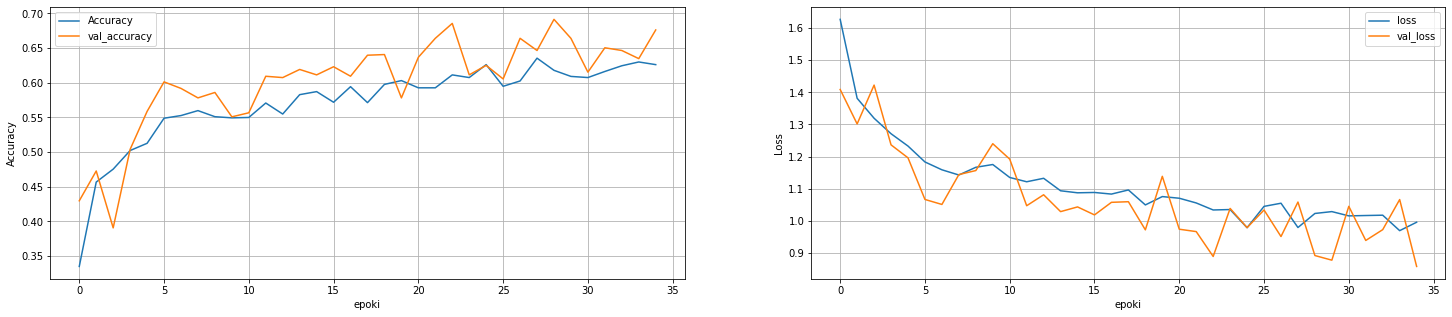

In [21]:
def plot_hist(history):

  fig, axes = plt.subplots(1,2, figsize=(25,5))
  axes[0].plot(history.history['accuracy'], label='Accuracy')
  axes[0].plot(history.history['val_accuracy'], label='val_accuracy')
  axes[0].legend(loc='best')
  axes[0].set(xlabel='epoki', ylabel='Accuracy')

  axes[1].plot(history.history['loss'], label='loss')
  axes[1].plot(history.history['val_loss'], label='val_loss')
  axes[1].legend(loc='best')
  axes[1].set(xlabel='epoki', ylabel='Loss')

  axes[0].grid()
  axes[1].grid()
  
  plt.show()

plot_hist(history)  

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255.) # obiekt klasy ImageDataGenerator()

#test_dir = '/content/intel_image/test'

# Tworzymy generator zbioru testowego                                                  
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=1, class_mode='categorical', shuffle=False )

y_prob = model.predict_generator(test_generator, test_generator.samples) # Stosujemy predict_generator() aby otrzymać predykcje naszych klas

# Nasza predykcja zwraca nam prawdopobieństwa przynależności do poszczególnej klasy
y_prob

Found 1578 images belonging to 6 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


array([[0.542891, 0.008398, 0.040223, 0.207239, 0.13947 , 0.061779],
       [0.742139, 0.000353, 0.001123, 0.001996, 0.017288, 0.237103],
       [0.399059, 0.186908, 0.015749, 0.017266, 0.027025, 0.353993],
       ...,
       [0.066769, 0.009226, 0.398219, 0.013339, 0.022436, 0.49001 ],
       [0.079108, 0.048532, 0.011358, 0.000656, 0.010336, 0.850011],
       [0.06557 , 0.021947, 0.000761, 0.000204, 0.000179, 0.911338]],
      dtype=float32)

In [23]:
# Meotoda argmax() zwróci nam argument gdzie dana tablica przyjmuje wartość maksymalną
# To będą nasze predykcje
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([0, 0, 0, ..., 5, 5, 5])

In [24]:
predictions  = pd.DataFrame({'Class': y_pred})
predictions

Class
0         0
1         0
2         0
3         0
4         0
...     ...
1573      5
1574      1
1575      5
1576      5
1577      5

[1578 rows x 1 columns]

In [25]:
# Prawdziwe klasy, które były przypisane do naszego zbioru testowego
y_true = test_generator.classes
y_true

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [26]:
y_pred = predictions['Class'].values
y_pred

array([0, 0, 0, ..., 5, 5, 5])

In [27]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

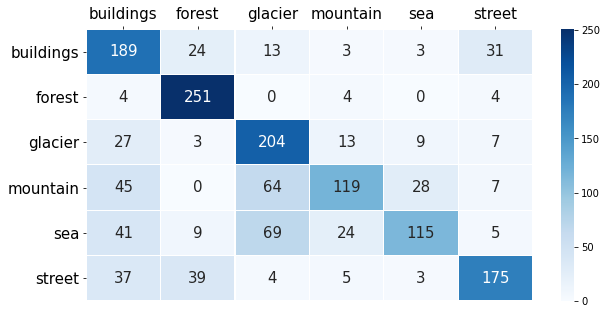

In [28]:
# Tworzymy macierz konfucji, która powie nam jak wygląda klasyfikacja
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 5))
g = sns.heatmap(cm, annot=True, fmt='d', linewidth=.2, cmap='Blues',
                xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(),
                annot_kws={"size": 15})

g.tick_params(labelsize=15)
g.xaxis.tick_top()
plt.yticks(rotation=0) 
plt.xticks(rotation=0) 
plt.show()

In [29]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

   buildings       0.55      0.72      0.62       263
      forest       0.77      0.95      0.85       263
     glacier       0.58      0.78      0.66       263
    mountain       0.71      0.45      0.55       263
         sea       0.73      0.44      0.55       263
      street       0.76      0.67      0.71       263

    accuracy                           0.67      1578
   macro avg       0.68      0.67      0.66      1578
weighted avg       0.68      0.67      0.66      1578



In [30]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors.head()

y_true  y_pred
buildings/1009.jpg        0       0
buildings/10161.jpg       0       0
buildings/10165.jpg       0       0
buildings/10228.jpg       0       0
buildings/10316.jpg       0       0

In [31]:
# Dodamy jeszcze jedną kolumnę.
# Tutaj sprawdzimy, czy te wartości się różnią.
# Jeśli się różnią, to zwrócimy wartość 1

errors['incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

y_true  y_pred  incorrect
buildings/1009.jpg        0       0          0
buildings/10161.jpg       0       0          0
buildings/10165.jpg       0       0          0
buildings/10228.jpg       0       0          0
buildings/10316.jpg       0       0          0
...                     ...     ...        ...
street/9843.jpg           5       5          0
street/9875.jpg           5       1          1
street/9903.jpg           5       5          0
street/9967.jpg           5       5          0
street/9978.jpg           5       5          0

[1578 rows x 3 columns]

In [32]:
# Tutaj mamy obiekty błędnie sklasyfikowane
errors[errors['incorrect'] == 1].index

Index(['buildings/10790.jpg', 'buildings/11306.jpg', 'buildings/11494.jpg',
       'buildings/11753.jpg', 'buildings/11945.jpg', 'buildings/12160.jpg',
       'buildings/12426.jpg', 'buildings/12533.jpg', 'buildings/12561.jpg',
       'buildings/12818.jpg',
       ...
       'street/7902.jpg', 'street/8530.jpg', 'street/8589.jpg',
       'street/886.jpg', 'street/8880.jpg', 'street/9043.jpg',
       'street/9234.jpg', 'street/9370.jpg', 'street/9685.jpg',
       'street/9875.jpg'],
      dtype='object', length=525)

(-0.5, 149.5, 149.5, -0.5)

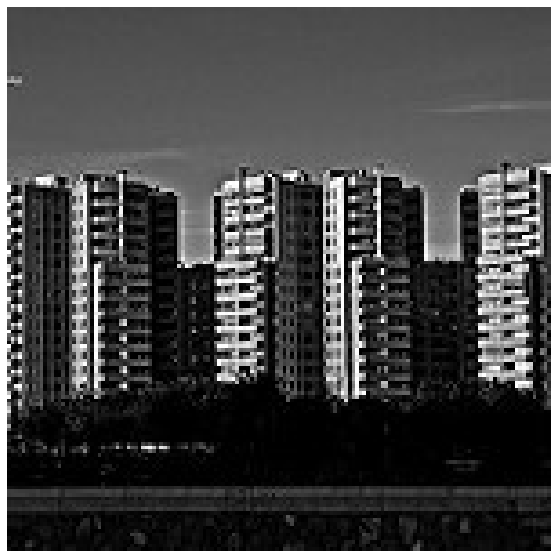

In [33]:
# Wyświeltimy przykładowe zdjęcia
new_test_dir = './images/test/new_test/'

img_path = os.path.join(test_buildings_dir, '11494.jpg') 

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis(False)